In [328]:
# Adaboost en pratique

import matplotlib.pyplot as plt
%matplotlib inline

#from visualization import plot_2d_data, plot_2d_classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score


import numpy as np
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

In [ ]:

X, y = make_moons(n_samples=500, noise=0.02)

X = np.concatenate((X, [[-1.15, 0.8]]))
y = np.concatenate((y, [1]))
# convert to -1, 1 labels from 0, 1
y = 2*y - 1

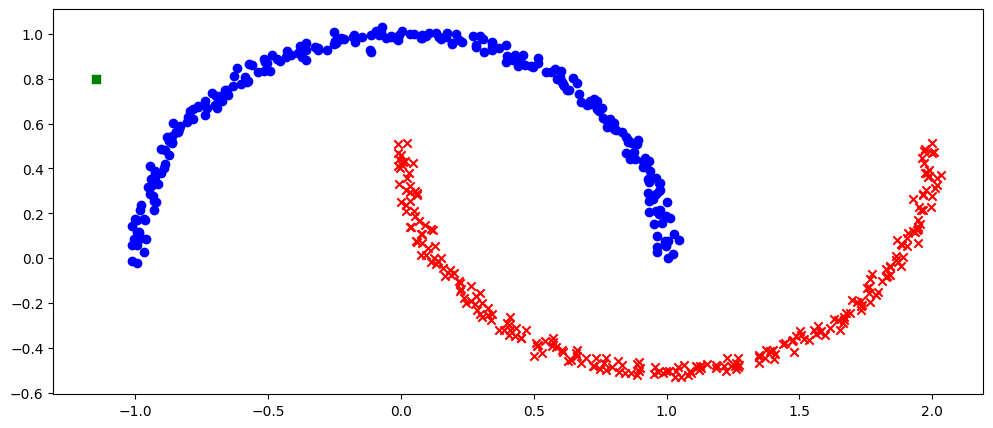

In [330]:
#Separate data points based on their class label
class_1 = X[y == -1]
class_2 = X[y == 1]

#subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5))

#create a scatter plot
ax.scatter(class_1[:,0], class_1[:,1], label = 'Class -1', c='blue', marker='o')
ax.scatter(class_2[:,0], class_2[:,1], label = 'Class 1', c='red', marker='x')

#plot the outlier
ax.scatter(-1.15, 0.8, label='Outlier', c='green', marker = 's')

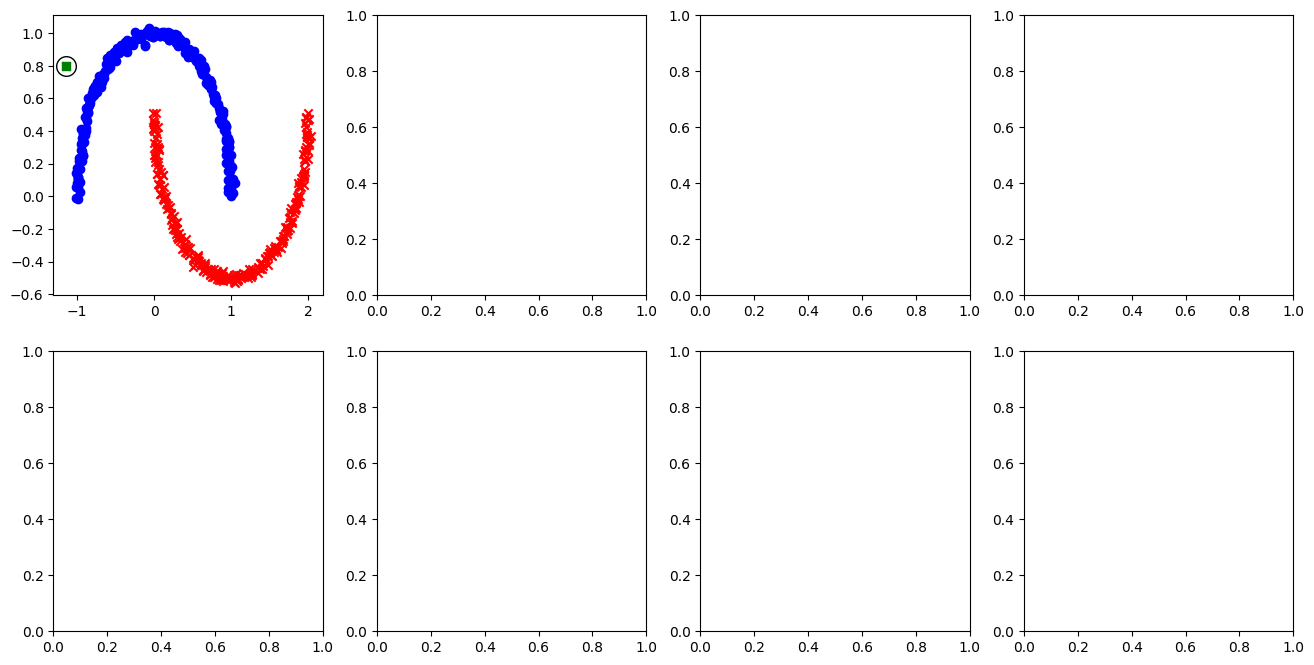

In [331]:
# initialize variables
n_samples, n_features = X.shape
n_estimators = 20
D = np.ones((n_samples,))
ensemble = []

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# plot the data set
ax[0, 0].scatter([-1.15], [0.8], marker='o', s=200, c='w', edgecolor='k')

axis_index = 0

#create a scatter plot
ax[0,0].scatter(class_1[:,0], class_1[:,1], label = 'Class -1', c='blue', marker='o')
ax[0,0].scatter(class_2[:,0], class_2[:,1], label = 'Class 1', c='red', marker='x')

#plot the outlier
ax[0,0].scatter(-1.15, 0.8, label='Outlier', c='green', marker = 's')

In [332]:
for t in range(n_estimators):
    D /= np.sum(D)

    s = D / np.max(D)
    s[(0.00 <= s) & (s < 0.25)] = 2
    s[(0.25 <= s) & (s < 0.50)] = 16
    s[(0.50 <= s) & (s < 0.75)] = 64
    s[(0.75 <= s) & (s <= 1.00)] = 128

    if t in [0, 1, 2, 4, 7, 11, 14]:
        axis_index += 1
        r, c = np.divmod(axis_index, 4)
        title = 'Iteration {0}: Sample weights'.format(t+1)

        #create a scatter plot
        ax[r,c].scatter(class_1[:,0], class_1[:,1], s=s[y == -1], label = 'Class -1', c='blue', marker='o')
        ax[r,c].scatter(class_2[:,0], class_2[:,1],s=s[y == 1], label = 'Class 1', c='red', marker='x')

        #plot the outlier
        ax[r,c].scatter(-1.15, 0.8, label='Outlier', c='green', marker = 's')


        #plot_2d_data(ax[r, c], X, y, alpha=0.75, s=s, title=title, colormap='RdBu')
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])

    ### --- MODELLING
    h = DecisionTreeClassifier(max_depth=1,
                               criterion='entropy')

    h.fit(X, y, sample_weight=D)
    ypred = h.predict(X)

    e = 1 - accuracy_score(y, ypred, sample_weight=D)
    a = 0.5 * np.log((1-e)/e)

    # update sample weights
    m = (y == ypred) * 1 + (y != ypred) * -1
    D *= np.exp(-a * m)

    ensemble.append((a, h))

fig.tight_layout()

# Exercice 2 - pruning

In [333]:
import sklearn.datasets
from sklearn.datasets import load_breast_cancer
X,y = load_breast_cancer(return_X_y = True)

%matplotlib inline

In [334]:
#hyperparameters to optimize
n_estimator_steps, n_folds = 5, 10
number_of_stumps = np.arange(5, 50, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

In [335]:
# decision stump for the modelling
stump = DecisionTreeClassifier(max_depth=4)

In [336]:
# looping on several values of number of models and splitting

for i, n in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        # Initialize Adaboost model
        model = AdaBoostClassifier(algorithm='SAMME',
                                   base_estimator=stump,
                                   n_estimators=n,
                                   learning_rate=0.1)
model.fit(X[trn, :], y[trn])
trn_err[i, j] = 1 - accuracy_score(y[trn],
                                   model.predict(X[trn, :]))

val_err[i, j] = 1 - accuracy_score(y[val],
                                      model.predict(X[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


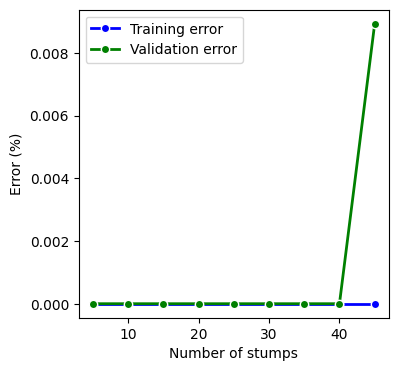

In [337]:
# Define a list of colors for the plots
cm = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fix, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='o', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Training error', 'Validation error'])
ax.set_xlabel('Number of stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()